In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

c:\Users\chane\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 전처리 변경점
사용 항목 : ‘자전거번호’, ‘대여일시’, ‘이용시간(분)’, ‘생년’, ‘대여대여소ID’, ‘반납대여소ID’
- ‘생년’ 항목에 결측치(’\N’) 행삭제 (3,717,287개)
- 파생변수 ‘나이’ 를 만들어 만 14세이상 65세미만 데이터 사용
- 이용자 종류 중 외국인 제외 (78,506개)

- 이용시간(분), 이용거리(M) 이 0인경우 오류 → 포함되면 행삭제
- 주제에 맞게 이용거리(M), 이용시간(분) 기준 정하기
→ 이용거리(M) 1km(1000m)미만 행삭제
→
- 반납시간은 있는데 반납대여소ID가 없는경우 강제반납 (분실,,,등)
→ 분실처리!

In [2]:
df_rental_23 = pd.read_csv('rental23_sampled_50.csv')
df_rental_23.shape

(12026747, 7)

In [3]:
df_rental_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12026747 entries, 0 to 12026746
Data columns (total 7 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   자전거번호    object
 1   대여일시     object
 2   이용시간(분)  int64 
 3   생년       object
 4   성별       object
 5   대여대여소ID  object
 6   반납대여소ID  object
dtypes: int64(1), object(6)
memory usage: 642.3+ MB


In [ ]:
df_rental_22 = pd.read_csv('rental22_sampled_50.csv')
df_rental_22.shape

(11660892, 7)

### 전처리 부분

In [ ]:
#생년에 'n'값인 경우 행 삭제
indices_to_drop = df_rental_22[df_rental_22['생년'] == '\\N'].index
df_rental_22 = df_rental_22.drop(indices_to_drop)
count_n = df_rental_22['생년'].str.contains(r'\\N', regex=False).sum()

print("개수:", count_n)

개수: 0


In [ ]:
#생년 열의 값을 전체적으로 확인
value_counts = df_rental_23['생년'].value_counts()
pd.set_option('display.max_rows',None)
print(value_counts)

생년
\N      874162
1998    571892
1995    494806
1994    493577
1996    486862
1997    469191
1993    460971
1992    440129
2000    409270
1999    393519
1991    389336
1990    320518
2001    284207
1989    273277
1988    232288
1987    220825
2004    211619
2003    205548
1986    204930
1981    202781
1983    201799
1982    200536
1985    195361
2002    191058
1980    188716
1984    181266
1979    180443
2006    178771
2005    170472
1977    159475
1974    158308
2007    158040
1978    156505
1973    155109
1976    154649
1972    152561
1971    151099
1975    150241
1970    136089
1969    129809
1968    118932
1967    102327
1966     88685
1965     82879
1964     68747
1962     61943
1963     60787
2008     57329
1961     53096
1960     49065
1959     39856
1901     37977
1958     33036
1957     26655
2009     23892
1956     20355
1955     17432
1954     14836
1952     10389
1953      8260
2010      6053
1950      5017
1948      4976
1951      4634
1949      3024
1947      2622
1945   

- Ex) 1900년생,2043년생 등 이상한 값이 발견
- 결측치 또한 발견 isna().sum()으로 나오지 않은 값도 존재 '\N'

In [ ]:
indices_to_drop = df_rental_23[df_rental_23['생년'] == '\\N'].index
df_rental_23 = df_rental_23.drop(indices_to_drop)
count_n = df_rental_23['생년'].str.contains(r'\\N', regex=False).sum()

print("개수:", count_n)

개수: 0


In [ ]:
df_rental_22['생년'] = pd.to_numeric(df_rental_22['생년'], errors='coerce')
df_rental_23['생년'] = pd.to_numeric(df_rental_23['생년'], errors='coerce')

In [ ]:
df_rental_23.info()
df_rental_22.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11152585 entries, 0 to 12026746
Data columns (total 7 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   자전거번호    object
 1   대여일시     object
 2   이용시간(분)  int64 
 3   생년       int64 
 4   성별       object
 5   대여대여소ID  object
 6   반납대여소ID  object
dtypes: int64(2), object(5)
memory usage: 680.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10676082 entries, 0 to 11660891
Data columns (total 7 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   자전거번호    object
 1   대여일시     object
 2   이용시간(분)  int64 
 3   생년       int64 
 4   성별       object
 5   대여대여소ID  object
 6   반납대여소ID  object
dtypes: int64(2), object(5)
memory usage: 651.6+ MB


- 이용시간을 IQR을 활용하여 이상치 판단 및 제거

In [ ]:
df_rental_22.head()

,자전거번호,대여일시,이용시간(분),생년,성별,대여대여소ID,반납대여소ID
0,SPB-41502,2022-07-15 07:35:40,11,1987,M,ST-348,ST-18
2,SPB-43426,2022-09-13 08:05:59,0,1991,M,ST-676,ST-676
3,SPB-48561,2022-12-31 07:54:35,16,1970,F,ST-2252,ST-454
4,SPB-32002,2022-09-15 11:49:21,10,1982,F,ST-555,ST-2897
5,SPB-53899,2022-09-06 13:13:57,25,1988,M,ST-285,ST-2958


- 거리가 0인 경우는 이상치로 먼저 판단 후 삭제 IQR 계산

In [ ]:
df_rental_22.shape

(10676082, 7)

In [ ]:
df_rental_22 = df_rental_22[(df_rental_22['이용시간(분)'] > 0)]
df_rental_22.shape

(10379100, 7)

In [ ]:
df_rental_23 = df_rental_23[(df_rental_23['이용시간(분)'] > 0)]
df_rental_23.shape

(10832035, 7)

In [ ]:
df_rental_22['이용시간(분)'].describe()
q1_22=df_rental_22['이용시간(분)'].quantile(0.25)
q3_22 = df_rental_22['이용시간(분)'].quantile(0.75)
iqr_22 = q3_22 - q1_22

print(df_rental_22['이용시간(분)'].quantile(0.75),iqr_22)

26.0 20.0


In [ ]:
df_rental_23['이용시간(분)'].describe()
q1_23=df_rental_23['이용시간(분)'].quantile(0.25)
q3_23 = df_rental_23['이용시간(분)'].quantile(0.75)
iqr_23 = q3_23 - q1_23
iqr_23

18.0

In [ ]:
upper_bound = q3_22 + 1.5 * iqr_22
df_rental_22.shape

(10379100, 7)

In [ ]:
df_rental_22 = df_rental_22[(df_rental_22['이용시간(분)'] > 0) & (df_rental_22['이용시간(분)'] <= upper_bound)]
df_rental_22.shape

(9508909, 7)

In [ ]:
upper_bound = q3_23 + 1.5 * iqr_23
df_rental_23.shape

(10832035, 7)

In [ ]:
df_rental_23 = df_rental_23[(df_rental_23['이용시간(분)'] > 0) & (df_rental_23['이용시간(분)'] <= upper_bound)]
df_rental_23.shape

(9778797, 7)

- 생년을 일반회원의 시작인 14세이상과 대중교통 요금이 무료가 되는 65세를 기준으로 대상 범위를 지정

In [ ]:
df_rental_22_dd = dd.from_pandas(df_rental_22, npartitions=10)
filtered_df_22_dd = df_rental_22_dd[(df_rental_22_dd['생년'] >= 1958) & (df_rental_22_dd['생년'] <= 2008)]
filtered_df_22 = filtered_df_22_dd.compute()  # 결과를 pandas DataFrame으로 변환

In [ ]:
filtered_df_22.shape

(9343550, 7)

In [ ]:
filtered_df_22 = df_rental_22[(df_rental_22['생년'] >= 1958) & (df_rental_22['생년'] <= 2008)]
print(filtered_df_22.head())

       자전거번호                 대여일시  이용시간(분)    생년 성별  대여대여소ID  반납대여소ID
0  SPB-41502  2022-07-15 07:35:40       11  1987  M   ST-348    ST-18
3  SPB-48561  2022-12-31 07:54:35       16  1970  F  ST-2252   ST-454
4  SPB-32002  2022-09-15 11:49:21       10  1982  F   ST-555  ST-2897
5  SPB-53899  2022-09-06 13:13:57       25  1988  M   ST-285  ST-2958
6  SPB-50821  2022-09-06 19:17:55       11  1995  M   ST-881   ST-889


In [ ]:
filtered_df_23 = df_rental_23[(df_rental_23['생년'] >= 1959) & (df_rental_23['생년'] <= 2009)]
print(filtered_df_23.head())

       자전거번호                 대여일시  이용시간(분)    생년   성별  대여대여소ID  반납대여소ID
2  SPB-66540  2023-07-20 11:48:05       37  1969    F  ST-1688  ST-2557
3  SPB-38040  2023-12-10 20:48:20       12  1963   \N  ST-1270   ST-725
5  SPB-53331  2023-07-10 21:22:59        8  1998    F  ST-3148  ST-2574
6  SPB-50607  2023-10-23 18:22:58        2  1967  NaN  ST-1995  ST-1002
7  SPB-47528  2023-12-29 12:05:19       29  1991   \N  ST-3118  ST-2037


In [ ]:
filtered_df_23['대여일시']=pd.to_datetime(filtered_df_23['대여일시'])

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\4147814981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_23['대여일시']=pd.to_datetime(filtered_df_23['대여일시'])


In [ ]:
filtered_df_22['대여일시']=pd.to_datetime(filtered_df_22['대여일시'])

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\147297140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_22['대여일시']=pd.to_datetime(filtered_df_22['대여일시'])


In [ ]:
df_rental_22['대여일시']=pd.to_datetime(df_rental_22['대여일시'])

In [ ]:
df_rental_23['대여일시']=pd.to_datetime(df_rental_23['대여일시'])

In [ ]:
df_rental_23.info()
df_rental_22.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9778797 entries, 2 to 12026746
Data columns (total 7 columns):
 #   Column   Dtype         
---  ------   -----         
 0   자전거번호    object        
 1   대여일시     datetime64[ns]
 2   이용시간(분)  int64         
 3   생년       int64         
 4   성별       object        
 5   대여대여소ID  object        
 6   반납대여소ID  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 596.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 9508909 entries, 0 to 11660890
Data columns (total 7 columns):
 #   Column   Dtype         
---  ------   -----         
 0   자전거번호    object        
 1   대여일시     datetime64[ns]
 2   이용시간(분)  int64         
 3   생년       int64         
 4   성별       object        
 5   대여대여소ID  object        
 6   반납대여소ID  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 580.4+ MB


***데이터 전처리 확인해봐야할것***
1. 결측치
2. 중복값(unique값) : 중복값 없음
3. 이상치(논리에 안맞는 데이터들 확인)


In [ ]:
#결측치 확인
print(f'22년도 대여 결측치:{df_rental_22.isna().sum()}')
print(f'22년도 대여 결측치:{df_rental_23.isna().sum()}')

22년도 대여 결측치:자전거번호           0
대여일시            0
이용시간(분)         0
생년              0
성별         348942
대여대여소ID         0
반납대여소ID         0
dtype: int64
22년도 대여 결측치:자전거번호           0
대여일시            0
이용시간(분)         0
생년              0
성별         311655
대여대여소ID         0
반납대여소ID         0
dtype: int64


성별에서 동일하게 많이 결측치가 발생했지만 지금 분석단계에서는 성별이 필요하지 않기 때문에 '성별'열을 제거

In [ ]:
df_rental_22.drop('성별',axis=1,inplace=True)
df_rental_23.drop('성별',axis=1,inplace=True)

In [ ]:
# df_rental_22.duplicated().sum()

In [ ]:
# duplicated_rows = df_rental_22[df_rental_22.duplicated()]
# print("중복된 값을 가진 행:")
# print(duplicated_rows)

In [ ]:
# df_rental_23.duplicated().sum()

## 2022년도와 2023년도 이용내역 비교
사용할 변수 = 대여일시,자전거번호
방법: 두 년도의 7-12월의 그래프를 만들어 비교하여 대중교통 요금 인상이 실질적인 사용량에 영향을 줬는지를 보기 위함

In [ ]:
cols = ['대여일시','자전거번호']
comp_df_22 = df_rental_22[cols]
comp_df_23 = df_rental_23[cols]


In [ ]:
sam_comp_df_22 = filtered_df_22[cols]
sam_comp_df_23 = filtered_df_23[cols]


In [ ]:
comp_df_22['year'] = comp_df_22['대여일시'].dt.year
comp_df_22['month'] = comp_df_22['대여일시'].dt.month

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2383857474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df_22['year'] = comp_df_22['대여일시'].dt.year
C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2383857474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df_22['month'] = comp_df_22['대여일시'].dt.month


In [ ]:
sam_comp_df_22['year'] = sam_comp_df_22['대여일시'].dt.year
sam_comp_df_22['month'] = sam_comp_df_22['대여일시'].dt.month

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\1985298409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sam_comp_df_22['year'] = sam_comp_df_22['대여일시'].dt.year
C:\Users\chane\AppData\Local\Temp\ipykernel_16068\1985298409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sam_comp_df_22['month'] = sam_comp_df_22['대여일시'].dt.month


In [ ]:
sam_comp_df_23['year'] = sam_comp_df_23['대여일시'].dt.year
sam_comp_df_23['month'] = sam_comp_df_23['대여일시'].dt.month

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2638480006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sam_comp_df_23['year'] = sam_comp_df_23['대여일시'].dt.year
C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2638480006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sam_comp_df_23['month'] = sam_comp_df_23['대여일시'].dt.month


In [ ]:
comp_df_23['year'] = comp_df_23['대여일시'].dt.year
comp_df_23['month'] = comp_df_23['대여일시'].dt.month

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\3252618338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df_23['year'] = comp_df_23['대여일시'].dt.year
C:\Users\chane\AppData\Local\Temp\ipykernel_16068\3252618338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df_23['month'] = comp_df_23['대여일시'].dt.month


In [ ]:
monthly_counts_22 = comp_df_22.groupby(['year', 'month']).size().reset_index(name='count')
print(monthly_counts_22)

   year  month    count
0  2022      7  1716449
1  2022      8  1510786
2  2022      9  1977757
3  2022     10  1887688
4  2022     11  1649896
5  2022     12   766333


In [ ]:
sam_monthly_counts_22 = sam_comp_df_22.groupby(['year', 'month']).size().reset_index(name='count')
print(sam_monthly_counts_22)

   year  month    count
0  2022      7  1687181
1  2022      8  1484684
2  2022      9  1945247
3  2022     10  1856091
4  2022     11  1620548
5  2022     12   749799


In [ ]:
sam_monthly_counts_23 = sam_comp_df_23.groupby(['year', 'month']).size().reset_index(name='count')
print(sam_monthly_counts_23)

   year  month    count
0  2023      7  1621027
1  2023      8  1617436
2  2023      9  1849023
3  2023     10  2162219
4  2023     11  1449476
5  2023     12   889019


In [ ]:
monthly_counts_23 = comp_df_23.groupby(['year', 'month']).size().reset_index(name='count')
print(monthly_counts_23)

   year  month    count
0  2023      7  1653043
1  2023      8  1648864
2  2023      9  1883584
3  2023     10  2203032
4  2023     11  1480317
5  2023     12   909957


C:\Users\chane\AppData\Local\Temp\ipykernel_16068\1794673116.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=monthly_counts_22, x='month', y='count', marker='o',ci=None)


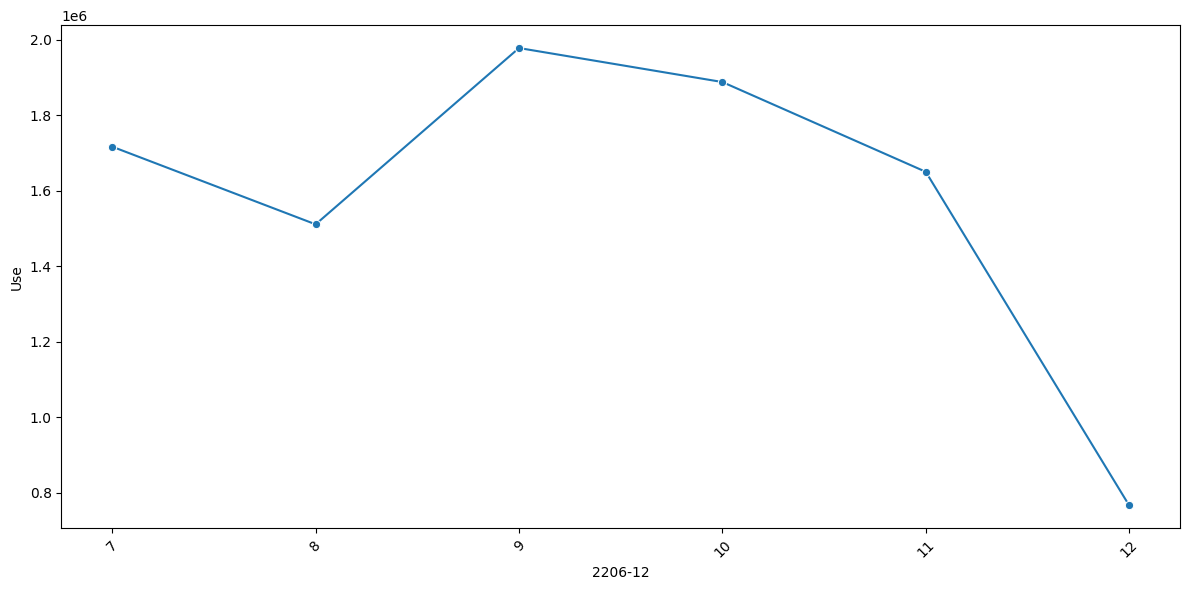

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts_22, x='month', y='count', marker='o',ci=None)
plt.xlabel('2206-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\872976464.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sam_monthly_counts_22, x='month', y='count', marker='o',ci=None)


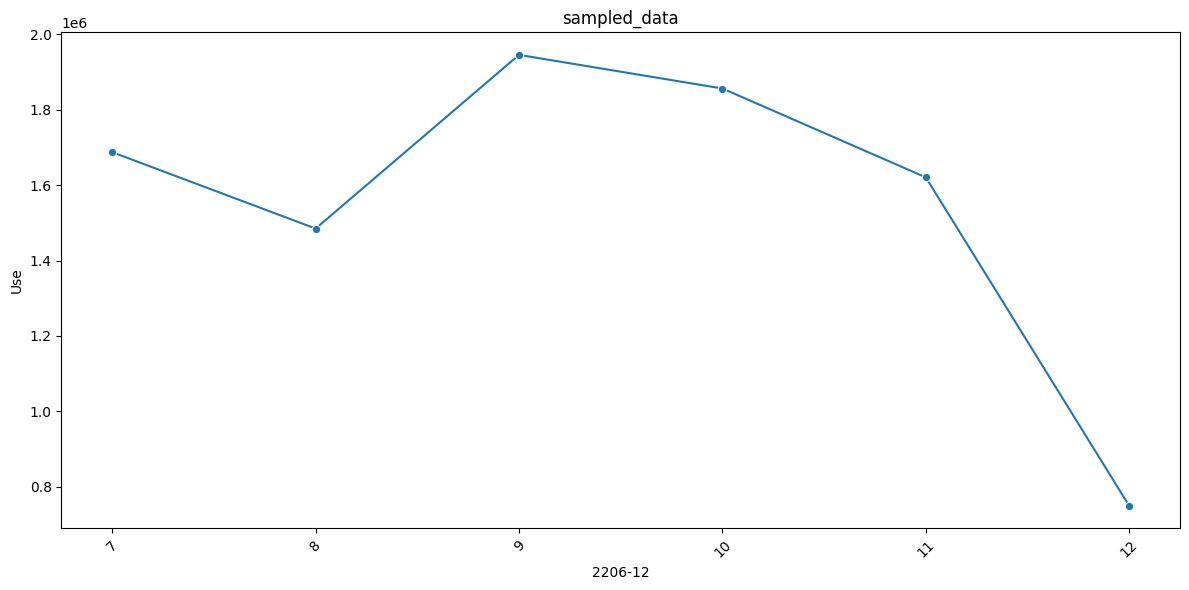

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sam_monthly_counts_22, x='month', y='count', marker='o',ci=None)
plt.title('sampled_data')
plt.xlabel('2206-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2815801146.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=monthly_counts_23, x='month', y='count', marker='o',ci=None)


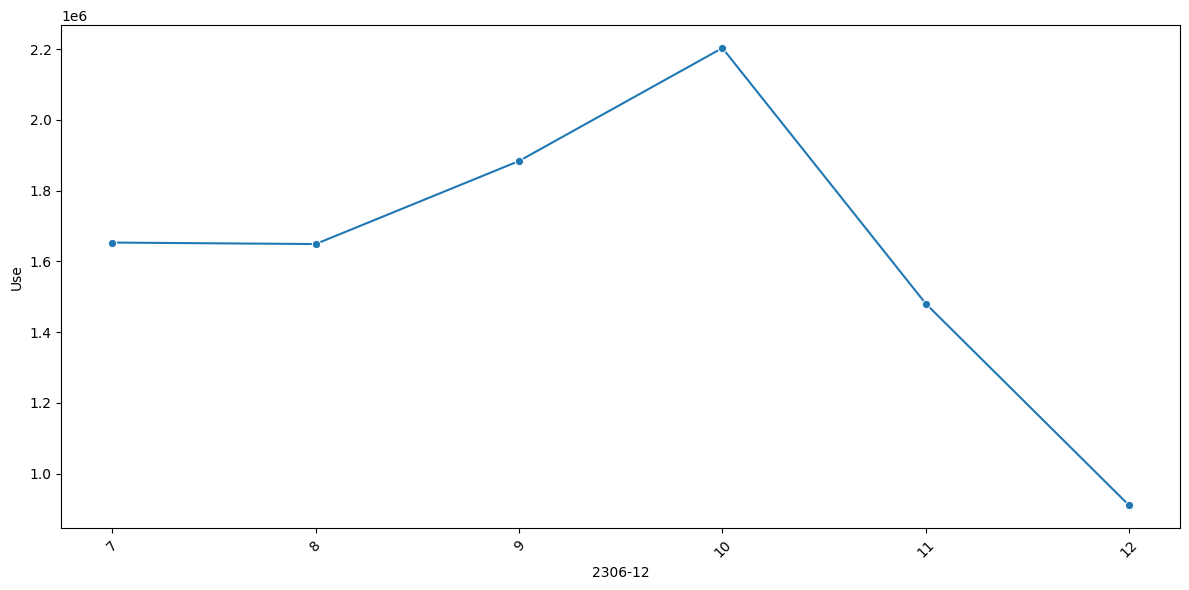

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts_23, x='month', y='count', marker='o',ci=None)
plt.xlabel('2306-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2647398245.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sam_monthly_counts_23, x='month', y='count', marker='o',ci=None)


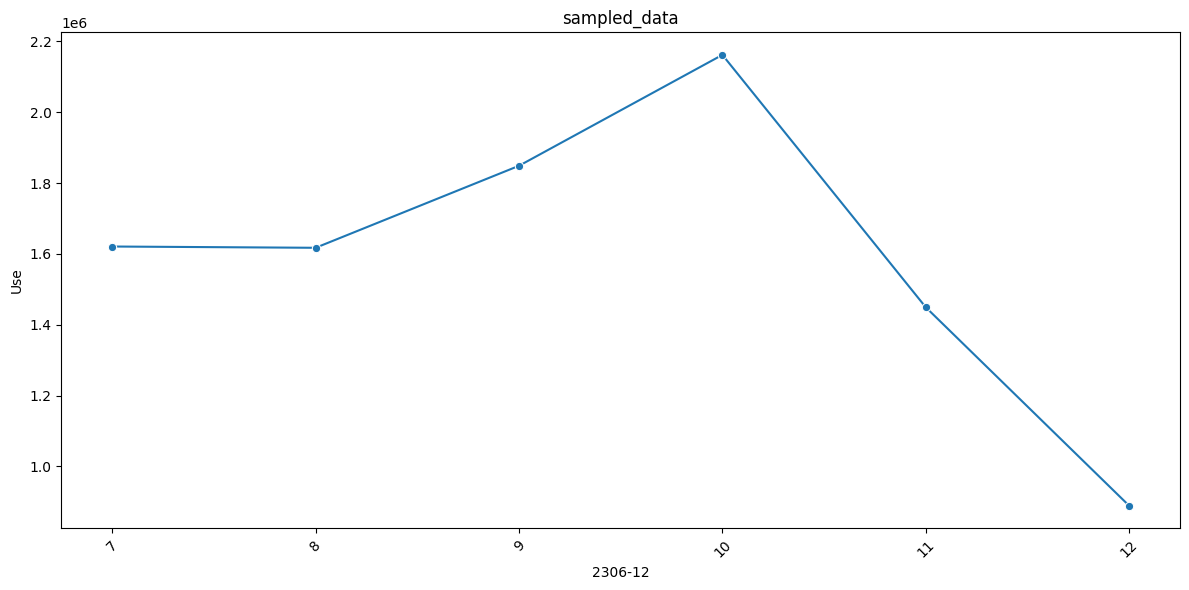

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sam_monthly_counts_23, x='month', y='count', marker='o',ci=None)
plt.title('sampled_data')
plt.xlabel('2306-12')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
sam_montly_combined = pd.concat([monthly_counts_22,monthly_counts_23])
sam_montly_combined

,year,month,count
0,2022,7,1716449
1,2022,8,1510786
2,2022,9,1977757
3,2022,10,1887688
4,2022,11,1649896
5,2022,12,766333
0,2023,7,1653043
1,2023,8,1648864
2,2023,9,1883584
3,2023,10,2203032


In [ ]:
montly_combined = pd.concat([monthly_counts_22,monthly_counts_23])
montly_combined

,year,month,count
0,2022,7,1716449
1,2022,8,1510786
2,2022,9,1977757
3,2022,10,1887688
4,2022,11,1649896
5,2022,12,766333
0,2023,7,1653043
1,2023,8,1648864
2,2023,9,1883584
3,2023,10,2203032


C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2337932849.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=montly_combined, x='month', y='count', hue='year', marker='o', ci=None)


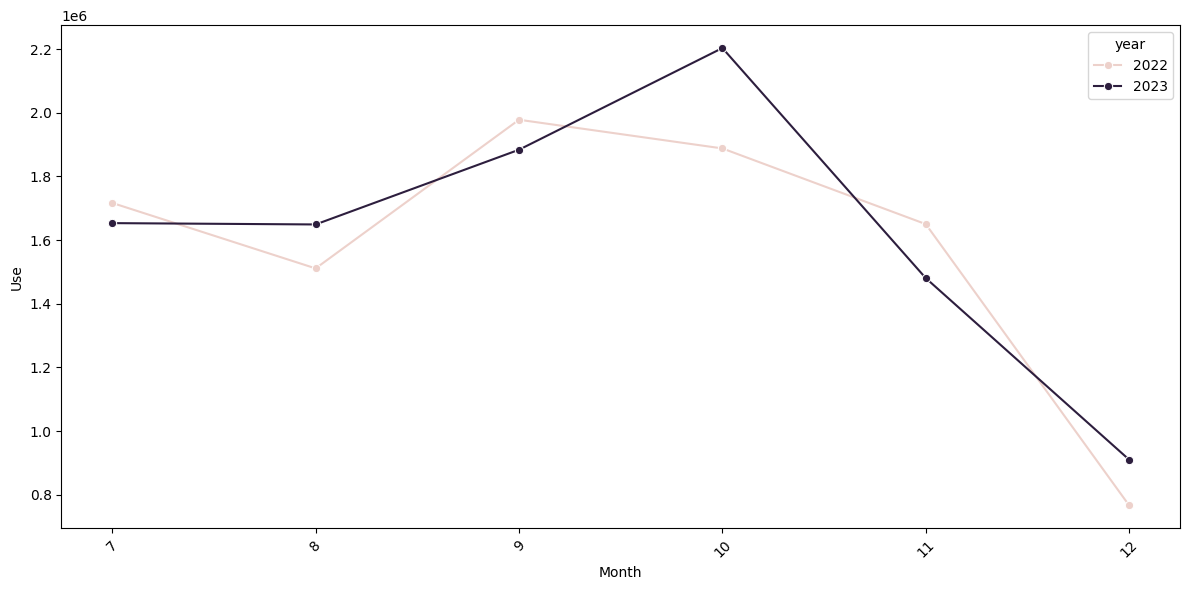

In [ ]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=montly_combined, x='month', y='count', hue='year', marker='o', ci=None)

plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2058154670.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=sam_montly_combined, x='month', y='count', hue='year', marker='o', ci=None)


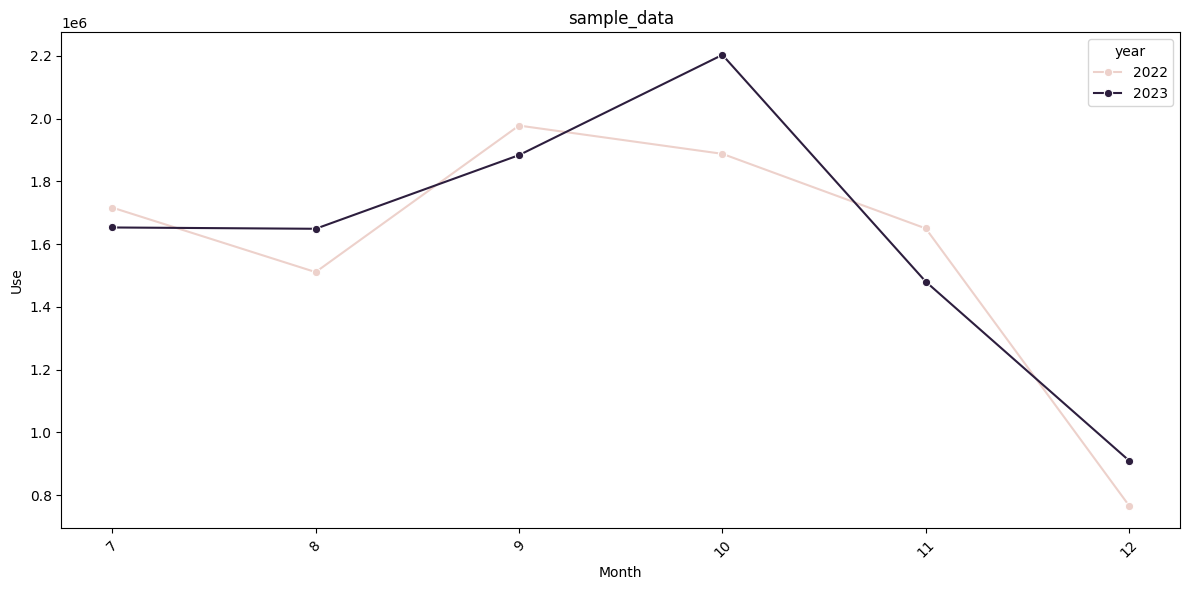

In [ ]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=sam_montly_combined, x='month', y='count', hue='year', marker='o', ci=None)
plt.title('sample_data')
plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

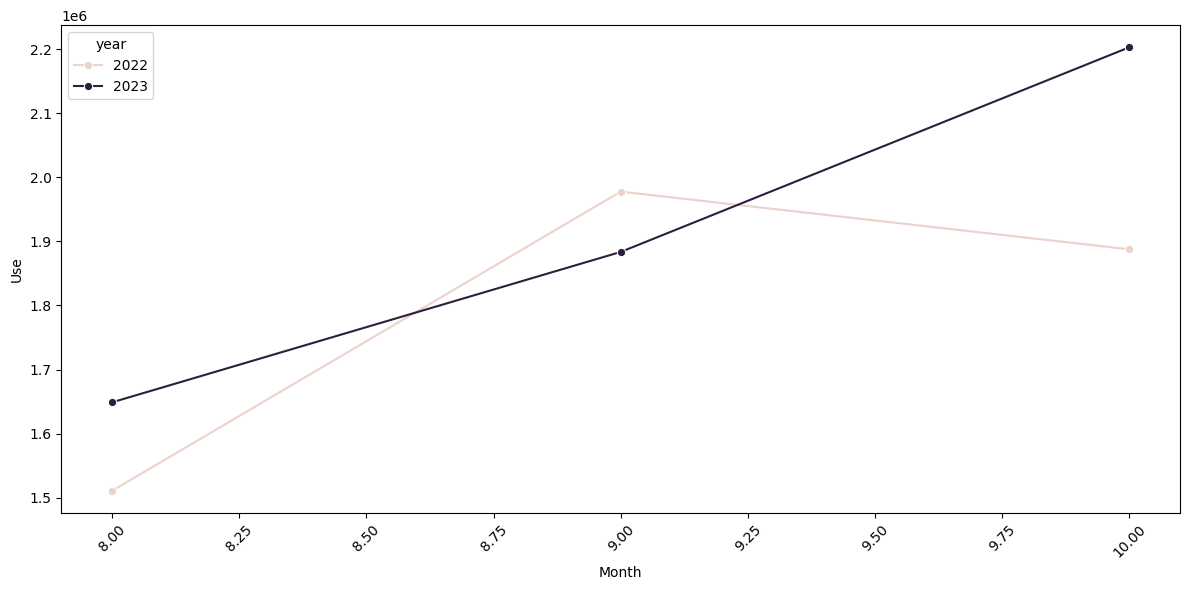

In [ ]:
filtered_data = montly_combined.query('8 <= month <= 10')
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='month', y='count', hue='year', marker='o')
plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

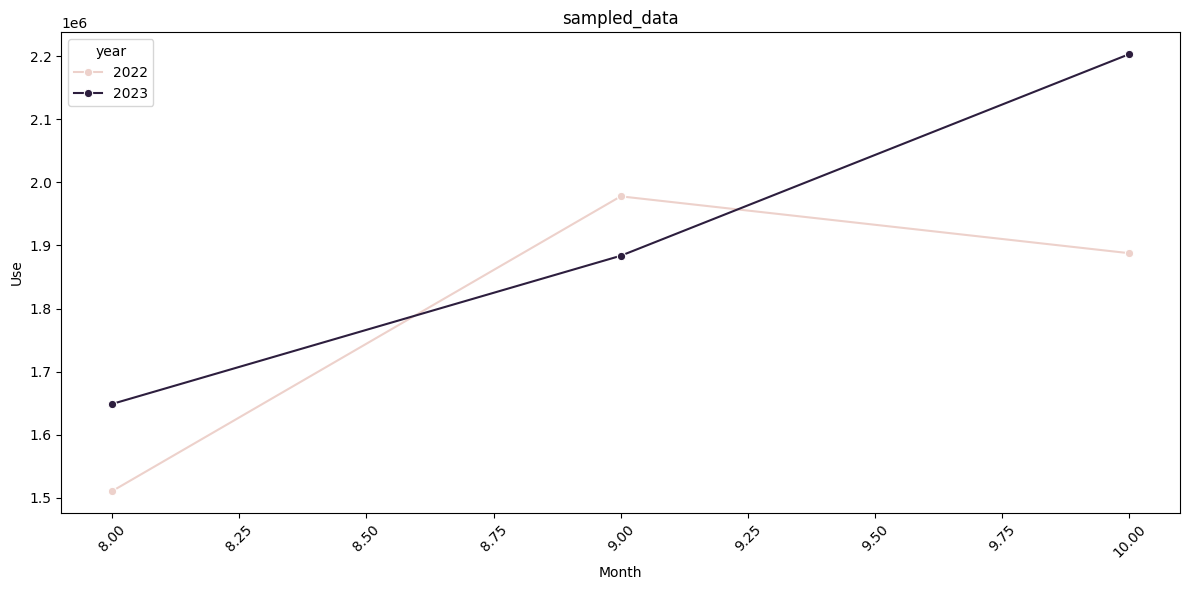

In [ ]:
sam_filtered_data = sam_montly_combined.query('8 <= month <= 10')
plt.figure(figsize=(12, 6))
sns.lineplot(data=sam_filtered_data, x='month', y='count', hue='year', marker='o')
plt.title('sampled_data')
plt.xlabel('Month')
plt.ylabel('Use')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
filtered_df_22.isna().sum()

자전거번호           0
대여일시            0
이용시간(분)         0
생년              0
성별         346337
대여대여소ID         0
반납대여소ID         0
dtype: int64

In [ ]:
#생년에 'n'값인 경우 행 삭제
filtered_df_22['생년'] = filtered_df_22['생년'].astype(str)
indices_to_drop = filtered_df_22[df_rental_22['생년'] == '\\N'].index
print("개수:", count_n)
filtered_df_22 = filtered_df_22.drop(indices_to_drop)
count_n = filtered_df_22['생년'].str.contains(r'\\N', regex=False).sum()

print("개수:", count_n)

C:\Users\chane\AppData\Local\Temp\ipykernel_16068\2894112374.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indices_to_drop = filtered_df_22[df_rental_22['생년'] == '\\N'].index


개수: 0
